# MAST387 Assignment 3

## Tristan Lafleur (40245238)



## A little instruction.

Please  store your solutions for the first 12 questions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.


You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_birth_weight_lower",
    "ex3_smoking_coefficient",
    "ex4_smoking_coefficient",
    "ex6_compare_white_black",
    "ex6_compare_white_black_tstat",
    "ex7_predictions",
    "ex8_smoking_coefficient",
    "ex10_num_high_drug_arrest",
    "ex11_diff_in_diff",
    "ex12_diff_in_diff_weighted",
}
```



In [1]:
results = {
    "ex2_birth_weight_lower": None,
    "ex3_smoking_coefficient": None,
    "ex4_smoking_coefficient": None,
    "ex6_compare_white_black": None,
    "ex6_compare_white_black_tstat": None,
    "ex7_predictions": None,
    "ex8_smoking_coefficient": None,
    "ex10_num_high_drug_arrest": None,
    "ex11_diff_in_diff": None,
    "ex12_diff_in_diff_weighted": None,
}



## Question 1: Maternal Smoking and Birth Weight



These days, it is widely understood that mothers who smoke during pregnancy risk exposing their babies to many health problems. This was not common knowledge fifty years ago. One of the first studies that addressed the issue of pregnancy and smoking was the Child Health and Development Studies, a comprehensive study of all babies born between 1960 and 1967 at the Kaiser Foundation Hospital in Oakland, CA. The original reference for the study is Yerushalmy (1964, American Journal of Obstetrics and Gynecology, pp. 505-518). The data and a summary of the study are in Nolan and Speed (2000, Stat Labs, Chapter 10) and can be found at [the book’s website.](https://www.stat.berkeley.edu/users/statlabs/)

There were about 15,000 families in the study. We will only analyze a subset of the data, in particular 1236 male single births where the baby lived at least 28 days. The researchers interviewed mothers early in their pregnancy to collect information on socioeconomic and demographic characteristics, including an indicator of whether the mother smoked during pregnancy. The variables in the dataset are described in the [code book here](https://ids-702-f19.github.io/Course-Website/hw/hw-02.html). In this question, we will attempt to use this data to answer the following questions:

1. Do mothers who smoke tend to give birth to babies with lower weights than mothers who do not smoke?
2. What is a likely range for the difference in birth weights for smokers and non-smokers?
3. Is there any evidence that the association between smoking and birth weight differs by mother’s race? If so, characterize those differences.
4. Are there other interesting associations with birth weight that are worth mentioning?


In [2]:
!pip install fastparquet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.8 MB/s eta 0:00:00


In [3]:
import pandas
import matplotlib.pyplot as plt
import numpy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import fastparquet
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso


### Question 1-1
Load the data "smoking.csv", which includes information on both biometrics of infants at birth, and information on mothers (variables prefixed with the letter "m"), from Moodle. This time I give you cleaned data to save your time, so please enjoy it.

In [110]:
#code here
smoking_dataframe = pandas.read_csv("smoking.csv")
smoking_dataframe = smoking_dataframe.rename(columns={"bwt.oz": "bwt"})
smoking_dataframe.head()


,id,date,gestation,bwt,parity,mrace,mage,med,mht,mpregwt,inc,smoke
0,4604,1598,148,116,7,7,28,1,66,135,2,0
1,7435,1527,181,110,7,7,27,1,64,133,1,0
2,7722,1563,204,55,11,7,35,3,65,140,6,0
3,2026,1503,225,132,4,7,28,2,67,148,3,0
4,3553,1638,233,105,4,7,34,3,61,130,3,0


### Question 1-2

Start by plotting the relationship between infant weight at birth and gestation (length of pregnancy (in days) at time of birth) for both mothers who smoke and those who do not in a single plot. Include regression lines for both populations (again, all on one plot).

Limit attention in the plot (and in subsequent questions) to children born after *more than* 225 days of gestation (there aren't really any observations for parents who smoke for less than that, so we don't get common support).

Does it seem like birthweights tend to be lower for the children of parents who smoke at a given gestational period? Store your answer as either `"yes"` or `"no"` in `ex2_birth_weight_lower`.

**NOTE:** This dataset has at least one column name that cause issues with Python (and seaborn. and statsmodels).

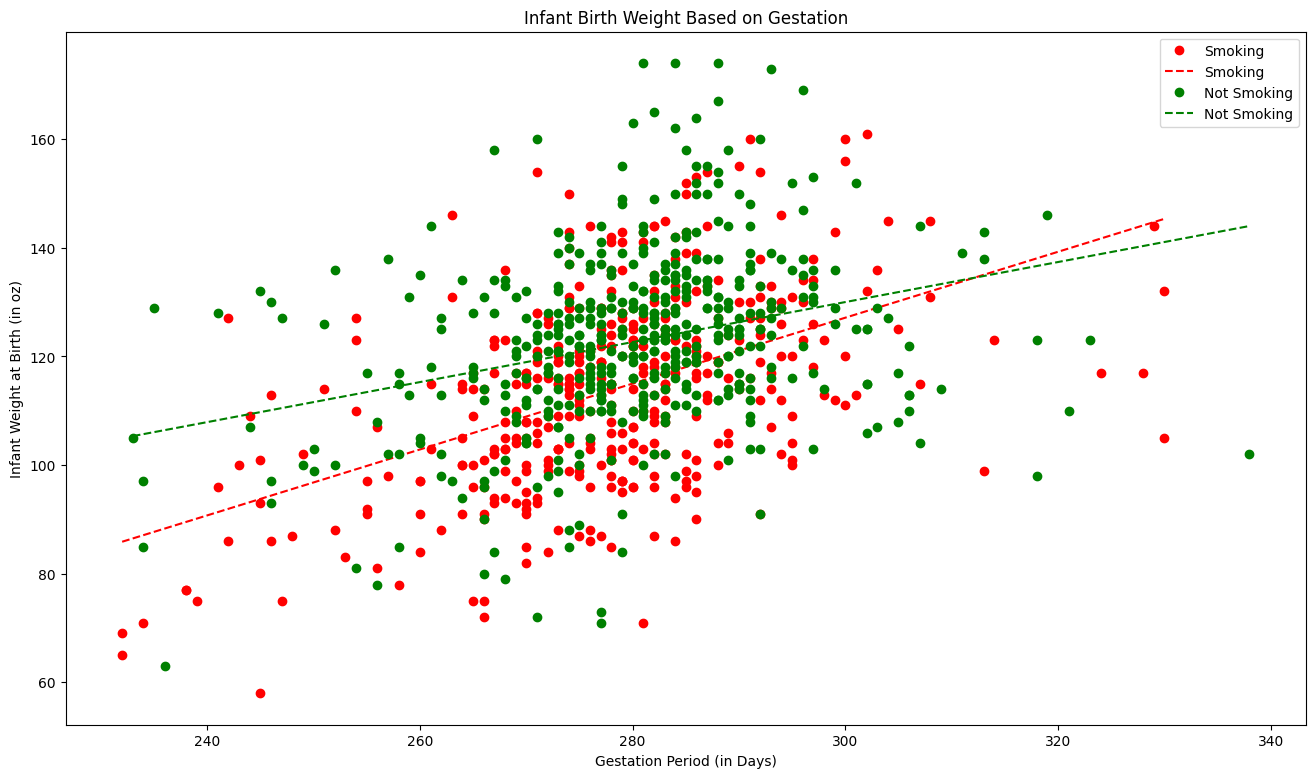

In [5]:
#code here
born_after_225_days = smoking_dataframe[smoking_dataframe.gestation > 225]
smoking_mothers = born_after_225_days[born_after_225_days.smoke == 1]
non_smoking_mothers = born_after_225_days[born_after_225_days.smoke == 0]

smoking_reg_line_coefs = numpy.polyfit(smoking_mothers.gestation, smoking_mothers["bwt"], deg=1)
smoking_poly_fn = numpy.poly1d(smoking_reg_line_coefs)

non_smoking_reg_line_coefs = numpy.polyfit(non_smoking_mothers.gestation, non_smoking_mothers["bwt"], deg=1)
non_smoking_poly_fn = numpy.poly1d(non_smoking_reg_line_coefs)

plt.figure(figsize=(16,9))
plt.plot(smoking_mothers.gestation, smoking_mothers["bwt"], "ro", smoking_mothers.gestation, smoking_poly_fn(smoking_mothers.gestation), "--r", label="Smoking")
plt.plot(non_smoking_mothers.gestation, non_smoking_mothers["bwt"], "go", non_smoking_mothers.gestation, non_smoking_poly_fn(non_smoking_mothers.gestation), "--g", label="Not Smoking")
plt.xlabel("Gestation Period (in Days)")
plt.ylabel("Infant Weight at Birth (in oz)")
plt.title("Infant Birth Weight Based on Gestation")
plt.legend()
plt.show()


In [6]:
results['ex2_birth_weight_lower'] = "No"


## Linear Regression

**PLEASE CONTINUE TO SUBSET FOR GESTATION GREATER THAN 225 DAYS for this section**

In [111]:
born_after_225_days = smoking_dataframe[smoking_dataframe.gestation > 225]


### Question 1-3
Now check this relationship using `statsmodels`. Regress birthweight on gestational period and whether the infant's mother smoked. Is your conclusion from the previous exercise confirmed? Store the coefficient for smoking in results under the key `"ex3_smoking_coefficient"`.

*Note:* coefficients are stored in the `.params` attribute of your fit model.

*Note 2:* you may hit a problem because of the name of one of your columns. You should probably be able to guess the problem given your experience with Python. Also, if you have trouble figuring out how to access the parameters from a fitted model, check out the docs [here](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html).


In [112]:
#code here
stats_model_smoke_reg = smf.ols(formula="bwt ~ gestation + smoke", data=born_after_225_days)
smoke_result = stats_model_smoke_reg.fit()
print(smoke_result.summary())

results['ex3_smoking_coefficient'] = smoke_result.params["smoke"]


                            OLS Regression Results                            
Dep. Variable:                    bwt   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     112.6
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           3.68e-44
Time:                        16:42:10   Log-Likelihood:                -3606.9
No. Observations:                 862   AIC:                             7220.
Df Residuals:                     859   BIC:                             7234.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.4386     10.878     -1.235      0.2

- It would in fact seem that the previous conclusion is legitamized

### Question 1-4
Now let's expand our model to also take into account mothers' pregnancy weight and race (make sure to treat race as a categorical variable!). Don't try to do any recoding of `mrace`, just turn it into a categorical. Does your interpretation of the `smoke` coefficient change? Store the new coefficient under the key `"ex4_smoking_coefficient"`.

In [113]:
#code here
stats_model_smoke_reg = smf.ols(formula="bwt ~ gestation + smoke + C(mrace)", data=born_after_225_days)
smoke_result = stats_model_smoke_reg.fit()
print(smoke_result.summary())

results['ex4_smoking_coefficient'] = smoke_result.params["smoke"]


                            OLS Regression Results                            
Dep. Variable:                    bwt   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     23.21
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           6.28e-42
Time:                        16:42:15   Log-Likelihood:                -3594.0
No. Observations:                 862   AIC:                             7212.
Df Residuals:                     850   BIC:                             7269.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.6687     11.041     -0.423

- No change of the interpretation of the `smoke` coefficient

### Question 1-5
Now let's test for whether there is an interaction between the mother's race and the effect of smoking.

Note that race is coded as follows:

```
mrace    mother’s race or ethnicity
         0-5= white
         6  = mexican
         7 = black
         8 = asian
         9 = mix
         99 = unknown
```

As most variation in this data is between "white" and other categories, first recode race to be an indicator for white and non-white for easier interpretation.

In [114]:
#code here
born_after_225_days.loc[(born_after_225_days.mrace >= 0) & (born_after_225_days.mrace <= 5), "mrace"] = 1
born_after_225_days.loc[born_after_225_days.mrace > 5, "mrace"] = 0
born_after_225_days


<ipython-input-114-8eccef187b7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  born_after_225_days.loc[(born_after_225_days.mrace >= 0) & (born_after_225_days.mrace <= 5), "mrace"] = 1
<ipython-input-114-8eccef187b7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  born_after_225_days.loc[born_after_225_days.mrace > 5, "mrace"] = 0


,id,date,gestation,bwt,parity,mrace,mage,med,mht,mpregwt,inc,smoke
4,3553,1638,233,105,4,0,34,3,61,130,3,0
5,3491,1705,234,85,7,0,33,1,67,130,2,0
6,6757,1444,234,97,0,0,26,5,65,112,6,0
7,6153,1405,235,129,3,0,24,4,66,135,1,0
8,8187,1669,236,63,0,1,24,5,58,99,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...
864,7781,1616,324,117,1,1,22,1,62,164,2,1
865,4344,1559,328,117,1,1,29,2,65,125,4,1
866,3917,1703,329,144,3,0,22,2,65,190,2,1
867,7707,1592,330,105,3,0,23,2,64,112,4,1


### Question 1-6
Now, using [post-regression test syntax](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.t_test.html) (not by running a new regression on a subpopulation), recover the coefficient and t-statistic for *whether smoking reduces birth weight for white mothers.*  Store the t-statistic of your test in `ex6_compare_white_black_tstat`.

**Hint:** Read to the BOTTOM of the post-regression test syntax documentation for how to specify hypotheses with strings.

How does this coefficient compare to that for non-white mothers? Is the reduction in birth weight associated with smoking for white mothers larger or smaller than for non-white mothers? Store your answer as either `"larger"` or `"smaller"` under the key `"ex6_compare_white_black"`.

**Note:** Please ensure your t-stat is stored as a single number, not an array or an array of arrays.

In [115]:
#code here
stats_model_smoke_reg = smf.ols(formula="bwt ~ gestation + smoke + mrace", data=born_after_225_days)
smoke_result = stats_model_smoke_reg.fit()
t_test = smoke_result.t_test("mrace = 1")
print(t_test)

results['ex6_compare_white_black_tstat'] = t_test.tvalue

t_test = smoke_result.t_test("mrace = 0")
print(t_test)

results['ex6_compare_white_black'] = "Larger"


                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.3219      1.225      2.712      0.007       1.917       6.726
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.3219      1.225      3.528      0.000       1.917       6.726


### Question 1-7
Now let's use this model to predict some values. Let's generate some hypothetical newborns:

```python
newborns = pd.DataFrame(
    {
        "smoke": [1, 1, 0, 0],
        "white": [True, False, True, False],
        "gestation": [253, 300, 248, 287],
        "mpregwt": [132, 129, 140, 139],
    }
)
```

Using the model you ran above with gestation, smoke, mpregwt, white, and the interaction of white and smoke, predict birth weights for these newborns. Store your predictions **in a list** under the key `"ex7_predictions"`.

Note that if you have different data types from those in this pretend dataset or different column names from those in the dataset you used to fit your model, you’ll get an error—just adjust the column names / data types to match the data you used to fit your model.

In [116]:
#code here
newborns = pandas.DataFrame(
    {
        "smoke": [1, 1, 0, 0],
        "mrace": [1, 0, 1, 0],
        "gestation": [253, 300, 248, 287],
        "mpregwt": [132, 129, 140, 139],
    }
)

stats_model_smoke_reg = smf.ols(formula="bwt ~ gestation + smoke + mrace", data=born_after_225_days)
smoke_result = stats_model_smoke_reg.fit()

predictions = smoke_result.predict(newborns)
results['ex7_predictions'] = predictions


## statsmodels versus R

A quick but important note: the tools that are made available in different packages is often a function of who uses those packages, and how they use them. By and large, nearly all statisticians use R, and so many stats tools (like automatic forward-model-selection or backwards-model-selection) have "convenience implementations" (single functions that do all the things you'd want to accomplish) in R, but aren't available as convenience packages in `statsmodels`. That's because `statsmodels` was mostly written by economists and social scientists who tend to feel model selection should be a function of theory not statistical performance (not taking sides: just reporting a difference that exists).

To be clear, you can still implement things like forward model selection yourself in Python -- just write a loop that tries different regressors and plots the resulting AICs! -- but it will often take a little more work. (Indeed, you can find examples of people [writing these loops on the web](https://planspace.org/20150423-forward_selection_with_statsmodels/)). And that's not to say that `statsmodels` doesn't have a TON of stuff (take a minute to just look over all the [examples of cool things you can do in statsmodels here](http://www.statsmodels.org/stable/examples/index.html)). Just don't be surprised if you ommissions that seem odd given what you see emphasized in stats courses.

This is one of the reasons that languages are sticky: once a group of people have invested in adding all the bells and whistles they like to a language, there are good reasons to not move to another language, even if the other language has some advantages. A statistician who likes the basic language organization of Python more than R, for example, may still stay with R because the packages already do everything a statistician wants to do, and so it's not worth having to re-implement common tasks in a new language.

## Logistic Regression

### Question 1-8
Now, using statsmodels, evaluate the impact of smoking on the likelihood a child is born prematurely (where "premature" is defined as gestation of *less than* 252 days).

For obvious reasons, **DO NOT USE OUR SUBSET FOR GESTATION GREATER THAN 225 DAYS** from above for this section.

For this model, please include mother’s pre-pregnancy weight, smoking status, and whether the mother is White (if you use all the racial categories, the model won’t converge). Please don’t include the interaction we used in the last question. Store the coefficient for smoking in `ex8_smoking_coefficient`.

In [14]:
#code here
premature_dataframe = smoking_dataframe
premature_dataframe["premature"] = 1
premature_dataframe.loc[premature_dataframe['gestation'] >= 252, "premature"] = 0
premature_dataframe.loc[(premature_dataframe.mrace >= 0) & (premature_dataframe.mrace <= 5), "mrace"] = 1
premature_dataframe.loc[premature_dataframe.mrace > 5, "mrace"] = 0

log_reg_model = smf.logit(formula="premature ~ mpregwt + smoke + mrace", data=premature_dataframe)
log_reg_results = log_reg_model.fit()


Optimization terminated successfully.
         Current function value: 0.187899
         Iterations 7


In [108]:
results['ex8_smoking_coefficient'] = log_reg_results.params.smoke


## Weighting

Let's now try using statsmodels on another dataset: drug arrest data from the state of California.

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in 2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale.

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common.

We want to run analysis on crime in California counties to see if, following drug legalization, there was a larger decline in violent crime in counties that had previously also had high drug arrest rates (to test the idea that violence was being generated by the drug trade, and that legalization would decrease this violence).

In simple analysis, we can treat counties as equally-weighted units of analysis. If we think that each county is a single "community", and we think crime and arrests is shaped at the level of communities (particularly when our community division is related to administrative boundaries that impact policing and government services, and is the case with counties), then this is reasonable.

But one might think that crime is determined at the individual level, or maybe neighborhood level, and so big counties should "count more" in our analysis.

(More formally, when we are fitting a regression model that picks parameter values to minimize the overall sum of squared errors, maybe we should pick values that to a better job of minimizing the errors for populous counties at the expense of not doing quite as good a job of minimizing the errors for smaller counties)

Here, let's use weighted least squares to weight observations based on population. This will allow bigger counties to influence our estimates more.

### Question 1-9
To begin, read in our data on California arrest rates and population from Moodle. You will see I've reshaped the data to long format for convenience. This data is stored as a parquet file, so you'll need to install an engine (I usually use `fastparquet` to load the data).


In [93]:
#code here
arrest_rates_dataframe = pandas.read_parquet('arrest_rates_and_population.parquet', engine='fastparquet')
arrest_rates_dataframe


variable,COUNTY,year,drug_arrest_rate,total_population,violent_arrest_rate
0,Alameda County,2009,0.003946,1457095.0,0.002963
1,Alameda County,2018,0.000652,1629615.0,0.002536
2,Alpine County,2009,0.001735,1153.0,0.006938
3,Alpine County,2018,0.000831,1203.0,0.004156
4,Amador County,2009,0.002655,38039.0,0.002629
...,...,...,...,...,...
111,Ventura County,2018,0.000863,847834.0,0.002679
112,Yolo County,2009,0.003182,192974.0,0.003031
113,Yolo County,2018,0.000564,212605.0,0.002705
114,Yuba County,2009,0.002976,70906.0,0.004993


### Question 1-10
To run our difference-in-difference in a regression framework, we need both an indicator variable for observations that occur after legalization (i.e. year == 2018), and an indicator for the population we consider treated (those who had drug arrest rates above the average 2009 drug arrest rate). Re-create those here.

As a check, store the number of counties that have a high drug arrest rate in 2009 under the key `"ex10_num_high_drug_arrest"`.

*Note:* if you want, you can also use the 2009 drug arrest rates as a continuous variable. This is a kind of "generalized difference-in-difference", in which we're just doing the continuous analogue of the thing we do when we split the sample into "high" and "low" 2009 arrest rates.

In [94]:
#code here
arrest_rates_dataframe["legalized"] = 1
arrest_rates_dataframe.loc[arrest_rates_dataframe.year < 2018, "legalized"] = 0

mean_pre_legal_arrest_rate = arrest_rates_dataframe[arrest_rates_dataframe.year == 2009].drug_arrest_rate.mean()

arrest_rates_dataframe["above_2009_arrest_rate"] = 1
arrest_rates_dataframe.loc[arrest_rates_dataframe.drug_arrest_rate < mean_pre_legal_arrest_rate, "above_2009_arrest_rate"] = 0

num_high_arrest_rate = len(arrest_rates_dataframe[(arrest_rates_dataframe.year == 2009) & (arrest_rates_dataframe.above_2009_arrest_rate == 1)])

results['ex10_num_high_drug_arrest'] = num_high_arrest_rate


### Exercise Question 1-11

Now regression the violent arrest rate on your two indicators and their interaction. The coefficient on the interaction is your "difference-in-difference" estimate! If you go back to your old homeworks, you should find the coefficient is exactly what you calculated. Store this coefficient under the key  `"ex11_diff_in_diff"`.

In [99]:
#code here
diff_in_diff_dataframe = arrest_rates_dataframe
control_group = diff_in_diff_dataframe[diff_in_diff_dataframe.above_2009_arrest_rate == 0]

treatment_group = diff_in_diff_dataframe[diff_in_diff_dataframe.above_2009_arrest_rate == 1]

control_group = control_group.drop(["COUNTY", "year", "drug_arrest_rate", "total_population", "above_2009_arrest_rate"], axis=1)

treatment_group = treatment_group.drop(["COUNTY", "year", "drug_arrest_rate", "total_population", "above_2009_arrest_rate"], axis=1)

control_group_numpy = control_group.groupby(by="legalized").mean().to_numpy().T

treatment_group_numpy = treatment_group.groupby(by="legalized").mean().to_numpy().T

indicator_numpy = numpy.vstack((control_group_numpy, treatment_group_numpy))
indicator_dataframe = pandas.DataFrame(indicator_numpy, index=["control", "treatment"], columns=["not_legal", "legal"])

print(f"Sanity check for Diff-in-Diff: {(indicator_dataframe.iloc[1, 1] - indicator_dataframe.iloc[1, 0]) - (indicator_dataframe.iloc[0, 1] - indicator_dataframe.iloc[0, 0])}")

indicator_dataframe


Sanity check for Diff-in-Diff: 0.0009664462133596734


,not_legal,legal
control,0.003403,0.003397
treatment,0.004178,0.005139


In [104]:
stats_model_violence_reg = smf.ols(formula="violent_arrest_rate ~ above_2009_arrest_rate + legalized + above_2009_arrest_rate * legalized", data=diff_in_diff_dataframe)
violence_result = stats_model_violence_reg.fit()
print(violence_result.params)

results['ex11_diff_in_diff'] = violence_result.params.iloc[3]


Intercept                           0.003403
above_2009_arrest_rate              0.000775
legalized                          -0.000005
above_2009_arrest_rate:legalized    0.000966
dtype: float64


### Question 1-12
Now let's do the same analysis, but this time using county population as a weight in a Weighted Least Squares regression (`smf.wls`). Just pass the keyword argument `weights` as a vector to weights (in this case, `arrests['total_population']`). Note that the `weights` argument is *outside* the formula, so you have to pass an actual vector of values, not just the name of a column.

Does your interpretation of the effects of drug legalization change? Store the new difference-in-difference coefficient under the key `"ex12_diff_in_diff_weighted"`.

In [106]:
#code here
stats_model_violence_rate = smf.wls(formula="violent_arrest_rate ~ above_2009_arrest_rate + legalized + above_2009_arrest_rate * legalized", data=arrest_rates_dataframe, weights=arrest_rates_dataframe.total_population)
violence_result = stats_model_violence_rate.fit()
print(violence_result.params)

results['ex12_diff_in_diff_weighted'] = violence_result.params.iloc[3]


Intercept                           0.002828
above_2009_arrest_rate              0.001053
legalized                           0.000056
above_2009_arrest_rate:legalized    0.001202
dtype: float64


## LASSO and Ridge

### Question 1-13

Let's go back a little to the `smoking` dataset. You will run a LASSO regression and a ridge regression to penalize the high correlated features. First, we will need to remove the feature `id`. Then, print the correlation matrix and tell me whether there are high correlated features. Why high correlations among features can harm our analysis?

Index(['date', 'gestation', 'bwt', 'parity', 'mrace', 'mage', 'med', 'mht',
       'mpregwt', 'inc', 'smoke', 'premature'],
      dtype='object')


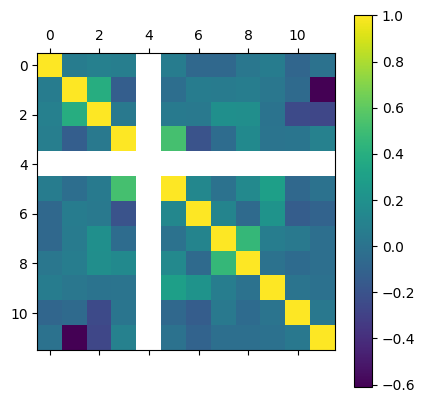

In [ ]:
#code here
lasso_dataframe = smoking_dataframe
lasso_dataframe = lasso_dataframe.drop("id", axis=1)

print(lasso_dataframe.columns)

plt.matshow(lasso_dataframe.corr())
plt.colorbar()
plt.show()


- Based on the graph, we can tell that the pairs of gestation and weight at birth, parity and mother's age and mother's height and mother's weight during pregnancy are highly correlated features.

- The impact of highly correlated features on the regression is due to the fact that they can have many solutions and those impact the predictive power of the regression

### Question 1-14

Yes, it is time to run a linear regression, a LASSO regression and a ridge regression to predict the birth weight `bwt.oz`. You will need to search the best parameters in your LASSO and ridge fittings. It is useful to plot the changes of the estimations of the coefficients of your models with respect to different penalty parameters. Give interpretation and comparations among the three fittings.

## Results

In [118]:
results


{'ex2_birth_weight_lower': 'No',
 'ex3_smoking_coefficient': -7.87842124448266,
 'ex4_smoking_coefficient': -8.249800035054532,
 'ex6_compare_white_black': 'Larger',
 'ex6_compare_white_black_tstat': array([[2.71157422]]),
 'ex7_predictions': 0    103.171509
 1    120.676115
 2    109.147479
 3    122.936928
 dtype: float64,
 'ex8_smoking_coefficient': 0.4252773397837852,
 'ex10_num_high_drug_arrest': 23,
 'ex11_diff_in_diff': 0.000966446213359674,
 'ex12_diff_in_diff_weighted': 0.0012023731489897728}